# Real vs Fake faces images Classifier

## Data
The dataset used for this project can be accessed at: https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k

In [1]:
import PIL
import PIL.Image as Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import os
import math

In [2]:
trainData = list()
validationData = list()
imgsPath = '/kaggle/input/rvf10k/rvf10k'

for dataFolder in os.listdir(imgsPath):
    for dataLabel in os.listdir(imgsPath+'/'+dataFolder):
        for imName in os.listdir(imgsPath+'/'+dataFolder+'/'+dataLabel):
            imPath = imgsPath+'/'+dataFolder+'/'+dataLabel+'/'+imName
            if dataFolder == 'train':
                if dataLabel == 'fake':
                    trainData.append((Image.open(imPath), 'fake'))
                else:
                    trainData.append((Image.open(imPath), 'real'))
            else:
                if dataLabel == 'fake':
                    validationData.append((Image.open(imPath), 'fake'))
                else:
                    validationData.append((Image.open(imPath), 'real'))

Num Real Samples: 3500
Num Fake samples: 3500


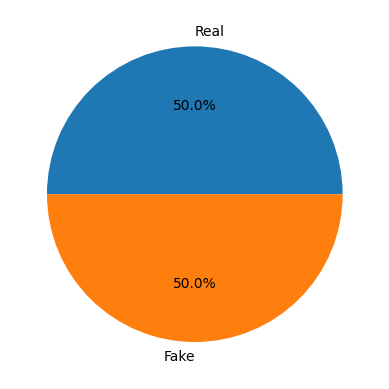

In [3]:
numReal = 0
numFake = 0


for sample in trainData:
    numReal += np.sum(sample[1] == 'real')
    numFake += np.sum(sample[1] == 'fake')

print(f'Num Real Samples: {numReal}\nNum Fake samples: {numFake}')
plt.pie([numReal, numFake], labels=['Real', 'Fake'], autopct='%1.1f%%')
plt.show()

In [4]:
print(np.unique([sample[0].size for sample in trainData]))
print(np.unique([sample[0].size for sample in validationData]))

# All images have the shape (256, 256)

[256]
[256]


In [5]:
def showRandomImgs(data=trainData, imgs=5, label='fake', cols=5):
    rows = math.ceil(imgs / cols)
    images = list()
    cont = 0
    while True:
        if cont == imgs:
            break
        randImg = random.choice(data)
        if randImg[1] == label:  
            images.append(randImg[0])
            cont += 1

    fig, ax = plt.subplots(rows, cols, figsize=(10, 10))
    indexImages = 0
    for r in range(rows):
        for c in range(cols):
            if indexImages == imgs:
                break
            if rows > 1:
                ax[r][c].imshow(images[indexImages])
                ax[r][c].axis('off')
                indexImages += 1
            else:
                ax[c].imshow(images[indexImages])
                ax[c].axis('off')
                indexImages += 1

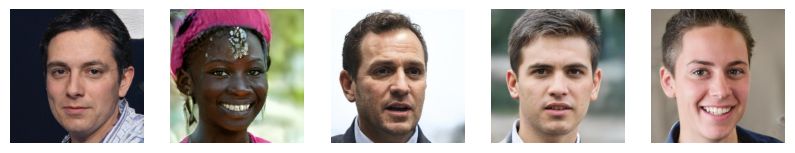

In [6]:
showRandomImgs(imgs=5, label='fake')

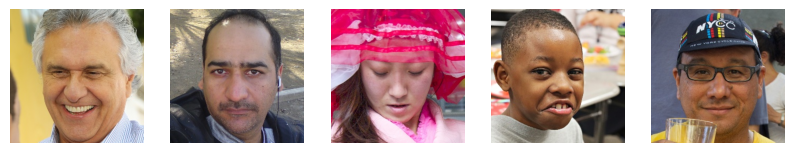

In [7]:
showRandomImgs(imgs=5, label='real')

In [8]:
class TrainFaceDataset(Dataset):
    def __init__(self, trainData, transforms=None):
        self.trainData = trainData
        self.len = len(trainData)
        self.transforms = transforms
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image = self.trainData[index][0]
        label = 0 if self.trainData[index][1] == 'real' else 1
        
        if self.transforms:
            image = self.transforms(image)
        
        return (image, label)

In [9]:
class ValidationFaceDataset(Dataset):
    def __init__(self, validationData, transforms=None):
        self.validationData = validationData
        self.len = len(validationData)
        self.transforms = transforms
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image = self.validationData[index][0]
        label = 0 if self.validationData[index][1] == 'real' else 1
        
        if self.transforms:
            image = self.transforms(image)
        
        return (image, label)

# Transforming images

In [10]:
trainTransformsComposed = transforms.Compose([transforms.ToTensor(), 
                                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                              transforms.RandomHorizontalFlip(p=0.5)])

validationTransformsComposed = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainDataset = TrainFaceDataset(trainData, transforms=trainTransformsComposed)
validationDataset = ValidationFaceDataset(validationData, transforms=validationTransformsComposed)

# CNN

In [11]:
class CNN(nn.Module):
    def __init__(self, input_dim=3, out_1=32, out_2=64, out_3=128, out_4=256, out_5=512):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_dim, out_channels=out_1, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(out_1)
        self.conv2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm2d(out_2)
        self.conv3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, padding=2)
        self.bn3 = nn.BatchNorm2d(out_3)
        self.conv4 = nn.Conv2d(in_channels=out_3, out_channels=out_4, kernel_size=3, padding=2)
        self.bn4 = nn.BatchNorm2d(out_4)
        self.conv5 = nn.Conv2d(in_channels=out_4, out_channels=out_5, kernel_size=3, padding=2)
        self.bn5 = nn.BatchNorm2d(out_5)
        self.fc1 = nn.Linear(512 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 4096)
        self.fc5 = nn.Linear(4096, 2)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.maxPool(x)
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.maxPool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        
        return x

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('GPU?', torch.cuda.is_available())

GPU? True


In [13]:
model = CNN()

In [14]:
model = model.to(device)

In [15]:
batch_size = 4
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validationDataset, batch_size=batch_size, shuffle=True)

# Defining Hyper parameters for training

In [16]:
learning_rate = 0.002
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
num_epochs = 50

In [17]:
def trainModel(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    results = {'costs': list(), 'accuracy': list()}
    for epoch in range(epochs):
        cost = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            cost += loss.item()
            optimizer.step()
            
        cost = cost / len(train_loader)
        
        accuracy = validateModel(model, validation_loader)['accuracy']
        results['accuracy'].append(accuracy.cpu())
        results['costs'].append(cost)
        print(f'Epoch: {epoch+1}/{epochs}\nLoss: {cost}\nAccuracy: {accuracy * 100:.2f}%\n____________________')
        
    return results

In [18]:
def validateModel(model, validation_loader):
    model.eval()
    validation_results = {'accuracy': 0, 'pred_labels': list(), 'true_labels': list()}
    correct = 0
    with torch.no_grad():
        for x, y in validation_loader:
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x.float())
            
            _, label = y_hat.max(1)
            validation_results['pred_labels'].extend(label.cpu().numpy())
            validation_results['true_labels'].extend(y.cpu().numpy())
            correct += (label == y).sum()
        
    validation_results['accuracy'] = correct / len(validationDataset)
    model.train()
    return validation_results

# Training model

In [19]:
training_results = trainModel(model, train_loader, criterion, optimizer, num_epochs)

Epoch: 1/50
Loss: 0.6976489904267448
Accuracy: 62.13%
____________________
Epoch: 2/50
Loss: 0.6744366150924138
Accuracy: 62.77%
____________________
Epoch: 3/50
Loss: 0.6430268696291106
Accuracy: 67.73%
____________________
Epoch: 4/50
Loss: 0.6175620901669775
Accuracy: 69.87%
____________________
Epoch: 5/50
Loss: 0.586605320508991
Accuracy: 69.27%
____________________
Epoch: 6/50
Loss: 0.5533568347649915
Accuracy: 74.23%
____________________
Epoch: 7/50
Loss: 0.5285336534678936
Accuracy: 76.27%
____________________
Epoch: 8/50
Loss: 0.49725824614507813
Accuracy: 77.33%
____________________
Epoch: 9/50
Loss: 0.4676356482218419
Accuracy: 68.37%
____________________
Epoch: 10/50
Loss: 0.43651624183676074
Accuracy: 73.80%
____________________
Epoch: 11/50
Loss: 0.4075012514085642
Accuracy: 79.93%
____________________
Epoch: 12/50
Loss: 0.3808554382630225
Accuracy: 84.93%
____________________
Epoch: 13/50
Loss: 0.3550414704228086
Accuracy: 82.17%
____________________
Epoch: 14/50
Loss: 0

# Analyzing training results

In [20]:
def plotCostAccuracy(costs, accuracy):
    fig, ax1 = plt.subplots()
    color = 'red'
    ax1.plot(costs, color=color)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost', color=color)
    
    ax2 = ax1.twinx()
    color = 'blue'
    ax2.plot(accuracy, color=color)
    ax2.set_ylabel('Accuracy', color=color)

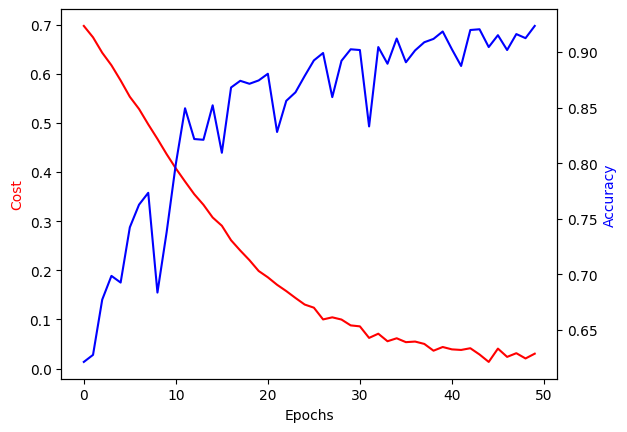

In [21]:
plotCostAccuracy(training_results['costs'], training_results['accuracy'])

In [22]:
def plotConfusionMatrix(model=model, validation_loader=validation_loader):
    validation_results = validateModel(model, validation_loader)
    pred_labels = validation_results['pred_labels']
    true_labels = validation_results['true_labels']      
    
    confusion_mtx = confusion_matrix(y_pred=pred_labels, y_true=true_labels)
    disp = ConfusionMatrixDisplay(confusion_mtx, display_labels=['Real', 'Fake'])
    disp.plot()

In [23]:
def plotMissClassified(model=model, validation_dataset=validationDataset, num_examples=5):
    cont = 0
    for x, y in DataLoader(validation_dataset, batch_size=1, shuffle=True):
        x = x.to(device)
        y = y.to(device)
        y_hat = model(x)
        _, predLabel = y_hat.max(1)
        if (predLabel != y):
            cont += 1
            fig, ax = plt.subplots(figsize=(3, 3))
            ax.imshow(x.cpu().permute(2, 3, 1, 0).squeeze())
            plt.title(f'True Label: {"Fake" if y.cpu().item() == 1 else "Real"} | Predicted Label: {"Fake" if predLabel == 1 else "Real"}')
            plt.show()
        if cont == num_examples:
            break

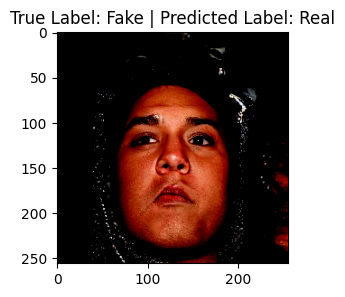

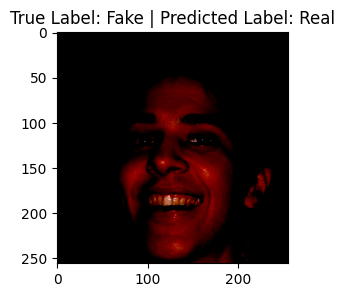

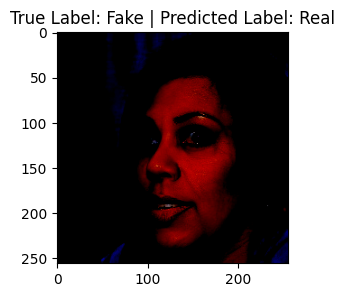

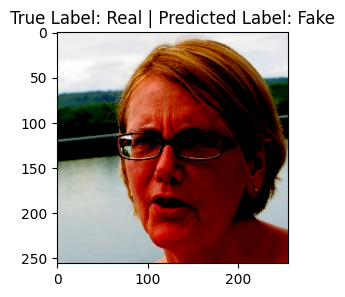

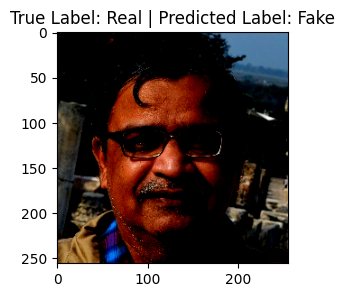

In [24]:
plotMissClassified()

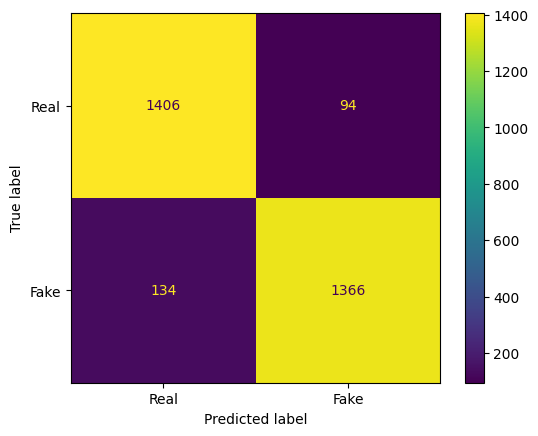

In [25]:
plotConfusionMatrix()

# Metrics

Accuracy: 0.9240
Precision: 0.9356
Recall: 0.9107
F1-score: 0.9230


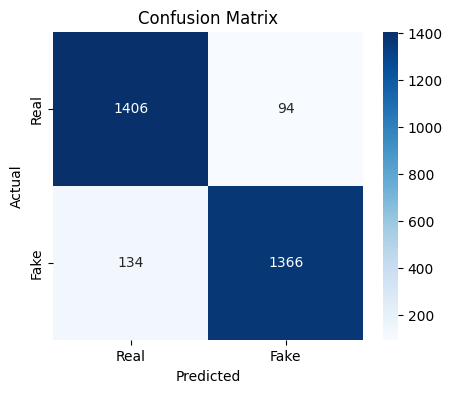

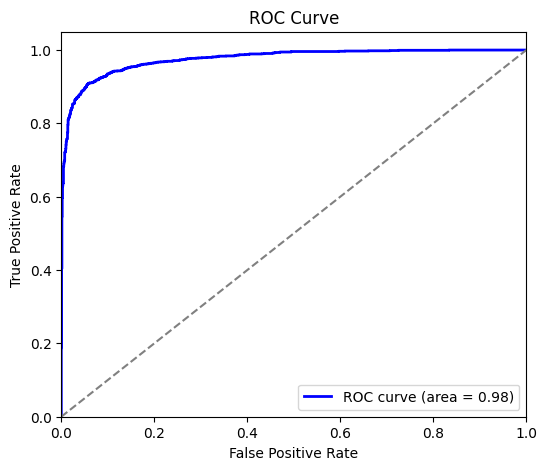

In [28]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Функція для оцінки моделі на тестовому наборі
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Ймовірність класу "Fake"
            preds = torch.argmax(outputs, dim=1)  # Передбачений клас
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Обчислення метрик
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    return y_true, y_pred, y_probs, conf_matrix

# Функція для побудови Confusion Matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Функція для побудови ROC-кривої
def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Функція для побудови графіка функції втрат
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(6, 5))
    plt.plot(train_losses, label="Train Loss", color="blue")
    plt.plot(val_losses, label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.show()

# Виконання оцінки
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_true, y_pred, y_probs, conf_matrix = evaluate_model(model, validation_loader, device)

# Побудова візуалізацій
plot_confusion_matrix(conf_matrix)
plot_roc_curve(y_true, y_probs)


# Align Image

In [29]:
import os
import urllib.request
import bz2
import shutil

target_directory = "/kaggle/working"
os.makedirs(target_directory, exist_ok=True)

url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
compressed_path = os.path.join(target_directory, "shape_predictor_68_face_landmarks.dat.bz2")
extracted_path = os.path.join(target_directory, "shape_predictor_68_face_landmarks.dat")

urllib.request.urlretrieve(url, compressed_path)

with bz2.BZ2File(compressed_path, "rb") as fr, open(extracted_path, "wb") as fw:
    shutil.copyfileobj(fr, fw)

print("Done! File saved as", extracted_path)

Done! File saved as /kaggle/working/shape_predictor_68_face_landmarks.dat


In [69]:
import os
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

def align_face(image_path, predictor_path, output_path=None, target_size=(224, 224), eye_shift_ratio=0.15, padding_ratio=0.5):
    """
    Вирівнює обличчя та опускає рівень очей на вихідному зображенні.

    Args:
        image_path (str): Шлях до зображення.
        predictor_path (str): Шлях до моделі dlib з ключовими точками.
        output_path (str, optional): Шлях для збереження результату.
        target_size (tuple, optional): Бажаний розмір вихідного зображення.
        eye_shift_ratio (float, optional): На скільки опустити рівень очей (від 0 до 0.3).
        padding_ratio (float, optional): Коефіцієнт для розміру додаткового простору навколо обличчя.

    Returns:
        np.array: Вирівняне зображення обличчя або None, якщо обличчя не знайдено.
    """
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Неможливо завантажити зображення: {image_path}")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        print("❌ Обличчя не знайдено!")
        return None

    for face in faces:
        landmarks = predictor(gray, face)
        left_eye = np.array([landmarks.part(36).x, landmarks.part(36).y])
        right_eye = np.array([landmarks.part(45).x, landmarks.part(45).y])

        delta_x = right_eye[0] - left_eye[0]
        delta_y = right_eye[1] - left_eye[1]
        angle = np.degrees(np.arctan2(delta_y, delta_x))

        eyes_center = (int((left_eye[0] + right_eye[0]) // 2), int((left_eye[1] + right_eye[1]) // 2))
        rotation_matrix = cv2.getRotationMatrix2D(eyes_center, angle, 1)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        padding = int(padding_ratio * h)  # Зменшено співвідношення для меншого збільшення
        y_shift = int(h * eye_shift_ratio)  # Зсуваємо вниз
        x, y = max(0, x - padding), max(0, y - padding - y_shift)
        w, h = min(image.shape[1] - x, w + 2 * padding), min(image.shape[0] - y, h + 2 * padding)

        face_aligned = rotated_image[y:y + h, x:x + w]
        if target_size:
            face_aligned = cv2.resize(face_aligned, target_size, interpolation=cv2.INTER_CUBIC)

        plt.imshow(cv2.cvtColor(face_aligned, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        if output_path:
            cv2.imwrite(output_path, face_aligned, [cv2.IMWRITE_JPEG_QUALITY, 95])
            print(f"✅ Вирівняне обличчя збережено як {output_path}!")

        return face_aligned

    return None


In [70]:
from PIL import Image
import torch

# Функція для підготовки нового зображення
def preprocess_image(image_path):
    validationTransforms = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Відкриваємо зображення
    image = Image.open(image_path).convert("RGB")
    
    # Застосовуємо трансформації
    image = validationTransforms(image)

    # Додаємо batch dimension (для PyTorch потрібно 4D тензор: [1, C, H, W])
    image = image.unsqueeze(0)

    return image

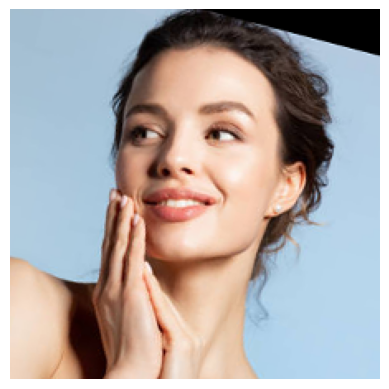

✅ Вирівняне обличчя збережено як /kaggle/working/aligned_face.jpg!


In [110]:
predictor_path = "/kaggle/working/shape_predictor_68_face_landmarks.dat"
image_path = "/kaggle/input/test-data/test.jpeg"
output_path = "/kaggle/working/aligned_face.jpg"

aligned_face = align_face(image_path, predictor_path, output_path)

In [111]:
import torch.nn.functional as F

input_image = preprocess_image(output_path)

# Перенесення на той самий пристрій, що й модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_image = input_image.to(device)

# Передбачення
model.eval()  # Переводимо модель у режим оцінки
with torch.no_grad():
    output = model(input_image)

# Додаємо Softmax для отримання ймовірностей
softmax_output = F.softmax(output, dim=1)

# Якщо це класифікаційна модель
predicted_class = torch.argmax(softmax_output, dim=1).item()
predicted_probability = softmax_output[0, predicted_class].item()

print("Predicted class:", predicted_class)
print("Predicted probability:", predicted_probability)


Predicted class: 0
Predicted probability: 0.9999983310699463
